The following code takes the daily grids created by machine learning, couples them with the closest points from the CMEMS L4 product and reshuffle both into time series for each lat-lon couple, named "time_series_data"

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np
from netCDF4 import Dataset
from scipy.spatial import cKDTree

# Directory containing the CSV files without extensions
csv_directory = '/DGFI8/H/work_marcello/giussani_machinelearning_data/WEST_AFRICA_ML_GRID_2023_COASTAL'

# Directory containing the NetCDF file from CMEMS
# downloaded through https://data.marine.copernicus.eu/product/SEALEVEL_GLO_PHY_L4_NRT_008_046/download
nc_directory = '/DGFI8/H/work_marcello/giussani_machinelearning_data/SEALEVEL_GLO_PHY_L4_REP_OBSERVATIONS_008_047'
nc_file = 'cmems_obs-sl_glo_phy-ssh_nrt_allsat-l4-duacs-0.25deg_P1D_1718195200333.nc'

# Initialize an empty DataFrame to store all data
all_data = pd.DataFrame()

# Loop through each file and aggregate the data
for filename in sorted(os.listdir(csv_directory)):
    if filename.startswith('WEST_AFRICA_ML_GRID_2023_'):
        date_str = filename.split('_')[-3] + '_' + filename.split('_')[-2] + '_' + filename.split('_')[-1]
        date = pd.to_datetime(date_str, format='%Y_%m_%d')
        file_path = os.path.join(csv_directory, filename)
        df = pd.read_csv(file_path)
        df['date'] = date
        all_data = pd.concat([all_data, df], ignore_index=True)

# Pivot the data to have dates as the index and (lat, lon) as columns
time_series_data = all_data.pivot_table(index='date', columns=['lat', 'lon'], values='sla_predicted')

# Load the CMEMS NetCDF data
nc_path = os.path.join(nc_directory, nc_file)
nc_data = Dataset(nc_path)

# Extract lat, lon, and sla from the NetCDF file
cmems_lat = nc_data.variables['latitude'][:]
cmems_lon = nc_data.variables['longitude'][:]
cmems_sla = nc_data.variables['sla'][:]

# Create a meshgrid for the lat and lon values
cmems_lon_grid, cmems_lat_grid = np.meshgrid(cmems_lon, cmems_lat)

# Flatten the grids to create a list of lat-lon pairs
cmems_coords = np.column_stack((cmems_lat_grid.ravel(), cmems_lon_grid.ravel()))

# Build a KDTree for fast lookup of nearest neighbors
tree = cKDTree(cmems_coords)

# Helper function to find the closest non-NaN location
def find_closest_non_nan(lat, lon, cmems_sla, tree, cmems_coords, lat_grid, lon_grid):
    distances, indices = tree.query([lat, lon], k=100)  # check the 100 closest points
    for index in indices:
        closest_lat, closest_lon = cmems_coords[index]
        i = np.where(lat_grid == closest_lat)[0][0]
        j = np.where(lon_grid == closest_lon)[0][0]
        if not np.isnan(cmems_sla[:, i, j]).all():  # Ensure there is at least one non-NaN value
            return closest_lat, closest_lon, cmems_sla[:, i, j]
    return None, None, None

# Create a DataFrame to store the combined time series data
combined_data = pd.DataFrame(index=time_series_data.index)

# Loop through each lat-lon location in the time series data
for lat, lon in time_series_data.columns:
    # Find the nearest CMEMS lat-lon location with non-NaN SLA values
    closest_lat, closest_lon, cmems_time_series = find_closest_non_nan(lat, lon, cmems_sla, tree, cmems_coords, cmems_lat, cmems_lon)
    
    if closest_lat is not None and closest_lon is not None:
        # Add the CMEMS time series to the combined data
        combined_data[(lat, lon, 'csv')] = time_series_data[(lat, lon)]
        combined_data[(lat, lon, 'cmems')] = cmems_time_series

# Select a random lat-lon location
random_location = random.choice(time_series_data.columns)

# Plot the time series for the selected location
plt.figure(figsize=(10, 6))
combined_data[(random_location[0], random_location[1], 'csv')].plot(label='CSV Data')
combined_data[(random_location[0], random_location[1], 'cmems')].plot(label='CMEMS Data')
plt.title(f'Sea Level Time Series for Location {random_location}')
plt.xlabel('Date')
plt.ylabel('Sea Level (sla_predicted)')
plt.legend()
plt.grid(True)
plt.show()


<Figure size 1000x600 with 1 Axes>

The following code creates an Hovmoller diagram based on latitude

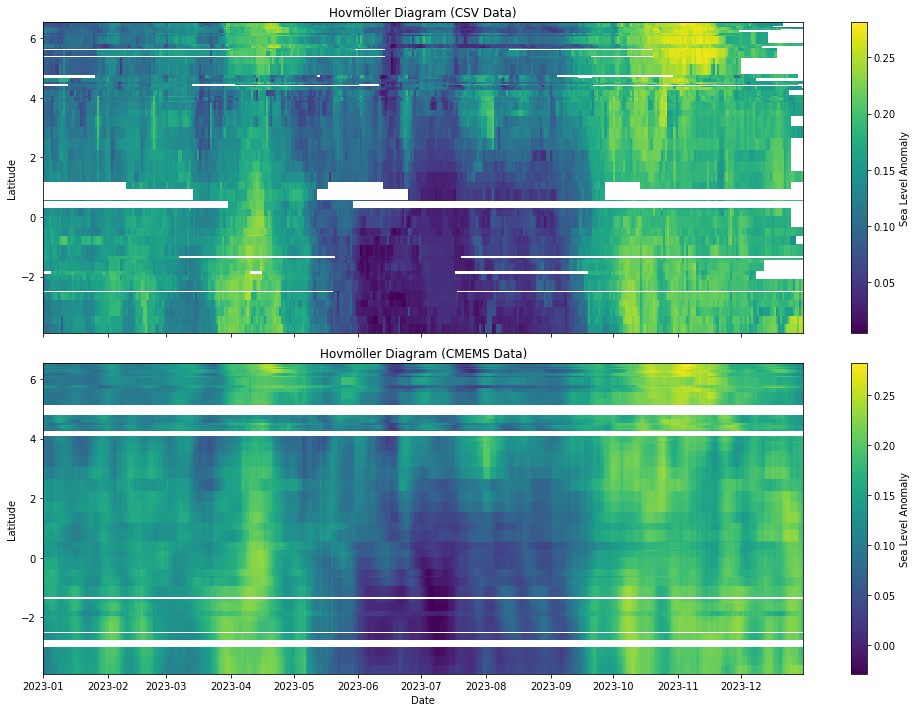

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np
from netCDF4 import Dataset
from scipy.spatial import cKDTree

# Directory containing the CSV files without extensions
csv_directory = '/DGFI8/H/work_marcello/giussani_machinelearning_data/WEST_AFRICA_ML_GRID_2023_COASTAL'

# Directory containing the NetCDF file from CMEMS
# downloaded through https://data.marine.copernicus.eu/product/SEALEVEL_GLO_PHY_L4_NRT_008_046/download
nc_directory = '/DGFI8/H/work_marcello/giussani_machinelearning_data/SEALEVEL_GLO_PHY_L4_REP_OBSERVATIONS_008_047'
nc_file = 'cmems_obs-sl_glo_phy-ssh_nrt_allsat-l4-duacs-0.25deg_P1D_1718195200333.nc'

# Initialize an empty DataFrame to store all data
all_data = pd.DataFrame()

# Loop through each file and aggregate the data
for filename in sorted(os.listdir(csv_directory)):
    if filename.startswith('WEST_AFRICA_ML_GRID_2023_'):
        date_str = filename.split('_')[-3] + '_' + filename.split('_')[-2] + '_' + filename.split('_')[-1]
        date = pd.to_datetime(date_str, format='%Y_%m_%d')
        file_path = os.path.join(csv_directory, filename)
        df = pd.read_csv(file_path)
        df['date'] = date
        all_data = pd.concat([all_data, df], ignore_index=True)

# Pivot the data to have dates as the index and (lat, lon) as columns
time_series_data = all_data.pivot_table(index='date', columns=['lat', 'lon'], values='sla_predicted')

# Load the CMEMS NetCDF data
nc_path = os.path.join(nc_directory, nc_file)
nc_data = Dataset(nc_path)

# Extract lat, lon, and sla from the NetCDF file
cmems_lat = nc_data.variables['latitude'][:]
cmems_lon = nc_data.variables['longitude'][:]
cmems_sla = nc_data.variables['sla'][:]

# Create a meshgrid for the lat and lon values
cmems_lon_grid, cmems_lat_grid = np.meshgrid(cmems_lon, cmems_lat)

# Flatten the grids to create a list of lat-lon pairs
cmems_coords = np.column_stack((cmems_lat_grid.ravel(), cmems_lon_grid.ravel()))

# Build a KDTree for fast lookup of nearest neighbors
tree = cKDTree(cmems_coords)

# Helper function to find the closest non-NaN location
def find_closest_non_nan(lat, lon, cmems_sla, tree, cmems_coords, lat_grid, lon_grid):
    distances, indices = tree.query([lat, lon], k=100)  # check the 100 closest points
    for index in indices:
        closest_lat, closest_lon = cmems_coords[index]
        i = np.where(lat_grid == closest_lat)[0][0]
        j = np.where(lon_grid == closest_lon)[0][0]
        if not np.isnan(cmems_sla[:, i, j]).all():  # Ensure there is at least one non-NaN value
            return closest_lat, closest_lon, cmems_sla[:, i, j]
    return None, None, None

# Create a DataFrame to store the combined time series data with (lat, lon, source) as columns
combined_data = pd.DataFrame(index=time_series_data.index)

# Loop through each lat-lon location in the time series data
for lat, lon in time_series_data.columns:
    # Find the nearest CMEMS lat-lon location with non-NaN SLA values
    closest_lat, closest_lon, cmems_time_series = find_closest_non_nan(lat, lon, cmems_sla, tree, cmems_coords, cmems_lat, cmems_lon)
    
    if closest_lat is not None and closest_lon is not None:
        # Add the CMEMS time series to the combined data
        combined_data[(lat, lon, 'csv')] = time_series_data[(lat, lon)]
        combined_data[(lat, lon, 'cmems')] = cmems_time_series

# Ensure columns are MultiIndex for easier manipulation
combined_data.columns = pd.MultiIndex.from_tuples(combined_data.columns)

# Create a DataFrame to store latitude-based time series data
latitude_data = pd.DataFrame(index=combined_data.index)

# Loop through each unique latitude
for lat in combined_data.columns.get_level_values(0).unique():
    # Extract the time series for the latitude from both csv and cmems data
    csv_series = combined_data.xs(key=lat, axis=1, level=0).xs('csv', axis=1, level=1)
    cmems_series = combined_data.xs(key=lat, axis=1, level=0).xs('cmems', axis=1, level=1)
    
    if not csv_series.empty and not cmems_series.empty:
        # Since there's only one longitude per latitude, take the first column
        latitude_data[(lat, 'csv')] = csv_series.iloc[:, 0]
        latitude_data[(lat, 'cmems')] = cmems_series.iloc[:, 0]

# Ensure columns are MultiIndex for easier manipulation
latitude_data.columns = pd.MultiIndex.from_tuples(latitude_data.columns)

# Generate Hovmöller diagram based on latitude
fig, ax = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Hovmöller diagram for CSV data
c1 = ax[0].pcolormesh(latitude_data.index, latitude_data.columns.get_level_values(0).unique(), latitude_data.xs('csv', axis=1, level=1).T, shading='auto', cmap='viridis')
ax[0].set_title('Hovmöller Diagram (CSV Data)')
ax[0].set_ylabel('Latitude')
fig.colorbar(c1, ax=ax[0], orientation='vertical', label='Sea Level Anomaly')

# Hovmöller diagram for CMEMS data
c2 = ax[1].pcolormesh(latitude_data.index, latitude_data.columns.get_level_values(0).unique(), latitude_data.xs('cmems', axis=1, level=1).T, shading='auto', cmap='viridis')
ax[1].set_title('Hovmöller Diagram (CMEMS Data)')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Latitude')
fig.colorbar(c2, ax=ax[1], orientation='vertical', label='Sea Level Anomaly')

plt.tight_layout()
plt.show()


Consider this: "In order to isolate the principal CTW frequencies,
the Bluelink data were filtered using a fifth-order Butterworth
bandpass filter, with frequency cutoffs (-3 dB) at
0.035 and 0.15 cycles per day (cpd). This passes oscillations
in the range 28.6–6.7 days." From: Woodham, R., G. B.Brassington, R.Robertson, and O.Alves (2013), Propagation characteristics of coastally trapped waves
on the Australian Continental Shelf, J. Geophys. Res. Oceans, 118, 4461–4473, doi:10.1002/jgrc.20317.

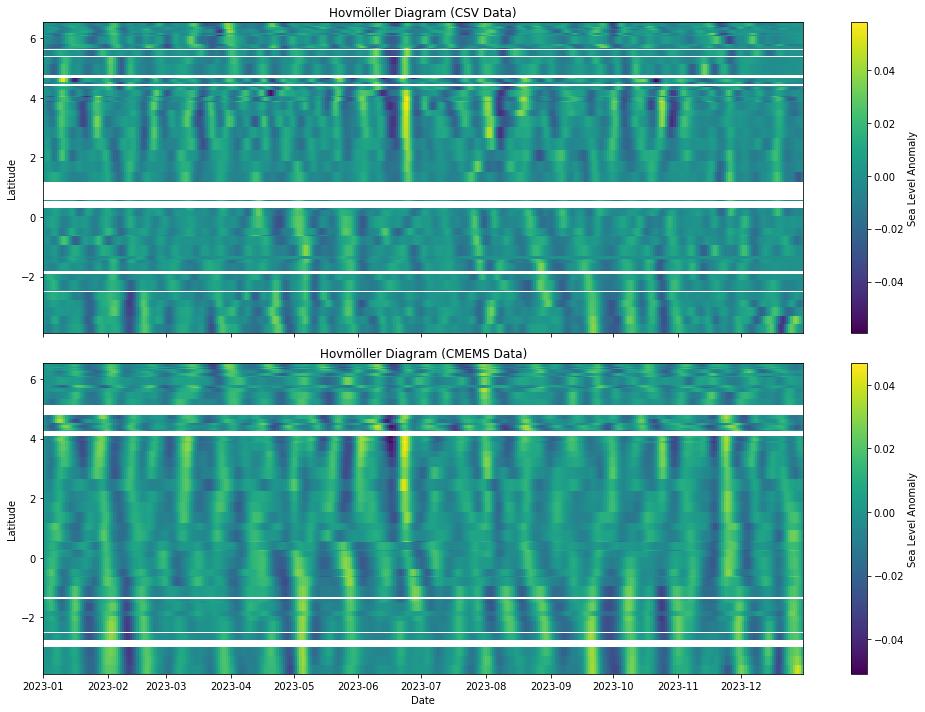

In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from netCDF4 import Dataset
from scipy.spatial import cKDTree
from scipy.signal import butter, filtfilt

# Butterworth bandpass filter functions
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

# Directory containing the CSV files without extensions
csv_directory = '/DGFI8/H/work_marcello/giussani_machinelearning_data/WEST_AFRICA_ML_GRID_2023_COASTAL'

# Directory containing the NetCDF file from CMEMS
nc_directory = '/DGFI8/H/work_marcello/giussani_machinelearning_data/SEALEVEL_GLO_PHY_L4_REP_OBSERVATIONS_008_047'
nc_file = 'cmems_obs-sl_glo_phy-ssh_nrt_allsat-l4-duacs-0.25deg_P1D_1718195200333.nc'

# Initialize an empty DataFrame to store all data
all_data = pd.DataFrame()

# Loop through each file and aggregate the data
for filename in sorted(os.listdir(csv_directory)):
    if filename.startswith('WEST_AFRICA_ML_GRID_2023_'):
        date_str = filename.split('_')[-3] + '_' + filename.split('_')[-2] + '_' + filename.split('_')[-1]
        date = pd.to_datetime(date_str, format='%Y_%m_%d')
        file_path = os.path.join(csv_directory, filename)
        df = pd.read_csv(file_path)
        df['date'] = date
        all_data = pd.concat([all_data, df], ignore_index=True)

# Pivot the data to have dates as the index and (lat, lon) as columns
time_series_data = all_data.pivot_table(index='date', columns=['lat', 'lon'], values='sla_predicted')

# Load the CMEMS NetCDF data
nc_path = os.path.join(nc_directory, nc_file)
nc_data = Dataset(nc_path)

# Extract lat, lon, and sla from the NetCDF file
cmems_lat = nc_data.variables['latitude'][:]
cmems_lon = nc_data.variables['longitude'][:]
cmems_sla = nc_data.variables['sla'][:]

# Create a meshgrid for the lat and lon values
cmems_lon_grid, cmems_lat_grid = np.meshgrid(cmems_lon, cmems_lat)

# Flatten the grids to create a list of lat-lon pairs
cmems_coords = np.column_stack((cmems_lat_grid.ravel(), cmems_lon_grid.ravel()))

# Build a KDTree for fast lookup of nearest neighbors
tree = cKDTree(cmems_coords)

# Helper function to find the closest non-NaN location
def find_closest_non_nan(lat, lon, cmems_sla, tree, cmems_coords, lat_grid, lon_grid):
    distances, indices = tree.query([lat, lon], k=100)  # check the 100 closest points
    for index in indices:
        closest_lat, closest_lon = cmems_coords[index]
        i = np.where(lat_grid == closest_lat)[0][0]
        j = np.where(lon_grid == closest_lon)[0][0]
        if not np.isnan(cmems_sla[:, i, j]).all():  # Ensure there is at least one non-NaN value
            return closest_lat, closest_lon, cmems_sla[:, i, j]
    return None, None, None

# Create a DataFrame to store the combined time series data with (lat, lon, source) as columns
combined_data = pd.DataFrame(index=time_series_data.index)

# Loop through each lat-lon location in the time series data
for lat, lon in time_series_data.columns:
    # Find the nearest CMEMS lat-lon location with non-NaN SLA values
    closest_lat, closest_lon, cmems_time_series = find_closest_non_nan(lat, lon, cmems_sla, tree, cmems_coords, cmems_lat, cmems_lon)
    
    if closest_lat is not None and closest_lon is not None:
        # Add the CMEMS time series to the combined data
        combined_data[(lat, lon, 'csv')] = time_series_data[(lat, lon)]
        combined_data[(lat, lon, 'cmems')] = cmems_time_series

# Ensure columns are MultiIndex for easier manipulation
combined_data.columns = pd.MultiIndex.from_tuples(combined_data.columns)

# Create a DataFrame to store latitude-based time series data
latitude_data = pd.DataFrame(index=combined_data.index)

# Apply Butterworth bandpass filter to the time series data
lowcut = 0.035
highcut = 0.15
fs = 1.0  # Sampling frequency in cycles per day

for lat in combined_data.columns.get_level_values(0).unique():
    # Extract the time series for the latitude from both csv and cmems data
    csv_series = combined_data.xs(key=lat, axis=1, level=0).xs('csv', axis=1, level=1)
    cmems_series = combined_data.xs(key=lat, axis=1, level=0).xs('cmems', axis=1, level=1)
    
    if not csv_series.empty and not cmems_series.empty:
        # Since there's only one longitude per latitude, take the first column
        csv_series_filled = csv_series.iloc[:, 0].interpolate(method='time')
        cmems_series_filled = cmems_series.iloc[:, 0].interpolate(method='time')
        csv_filtered = butter_bandpass_filter(csv_series_filled, lowcut, highcut, fs)
        cmems_filtered = butter_bandpass_filter(cmems_series_filled, lowcut, highcut, fs)
        latitude_data[(lat, 'csv')] = csv_filtered
        latitude_data[(lat, 'cmems')] = cmems_filtered

# Ensure columns are MultiIndex for easier manipulation
latitude_data.columns = pd.MultiIndex.from_tuples(latitude_data.columns)

# Generate Hovmöller diagram based on latitude
fig, ax = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Hovmöller diagram for CSV data
c1 = ax[0].pcolormesh(latitude_data.index, latitude_data.columns.get_level_values(0).unique(), latitude_data.xs('csv', axis=1, level=1).T, shading='auto', cmap='viridis')
ax[0].set_title('Hovmöller Diagram (CSV Data)')
ax[0].set_ylabel('Latitude')
fig.colorbar(c1, ax=ax[0], orientation='vertical', label='Sea Level Anomaly')

# Hovmöller diagram for CMEMS data
c2 = ax[1].pcolormesh(latitude_data.index, latitude_data.columns.get_level_values(0).unique(), latitude_data.xs('cmems', axis=1, level=1).T, shading='auto', cmap='viridis')
ax[1].set_title('Hovmöller Diagram (CMEMS Data)')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Latitude')
fig.colorbar(c2, ax=ax[1], orientation='vertical', label='Sea Level Anomaly')

plt.tight_layout()
plt.show()


In [4]:
lons = []
lats = []

for k in range(len(time_series_data.T.index)):
    
    lons.append(time_series_data.T.index[k][1])
    lats.append(time_series_data.T.index[k][0])

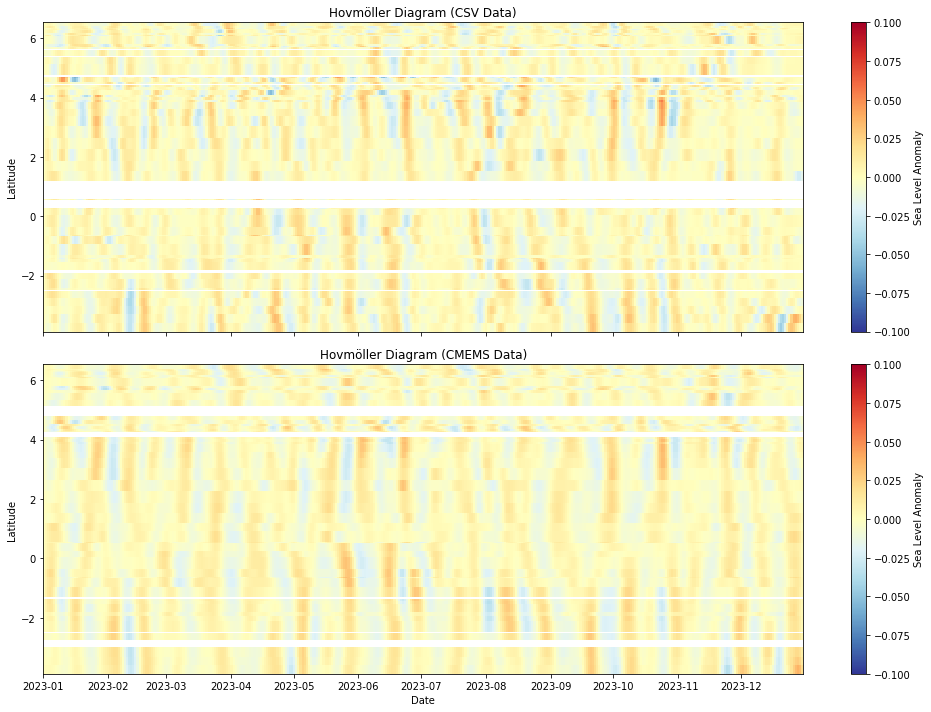

In [5]:
fig, ax = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

c1 = ax[0].pcolormesh(latitude_data.index, latitude_data.columns.get_level_values(0).unique(), 
                      latitude_data.xs('csv', axis=1, level=1).T-np.nanmean(latitude_data.xs('csv', axis=1, level=1).T,axis=0), 
                      shading='auto', cmap='RdYlBu_r',
                     vmax=.1,vmin=-.1)
ax[0].set_title('Hovmöller Diagram (CSV Data)')
ax[0].set_ylabel('Latitude')
fig.colorbar(c1, ax=ax[0], orientation='vertical', label='Sea Level Anomaly')

# Hovmöller diagram for CMEMS data
c2 = ax[1].pcolormesh(latitude_data.index, latitude_data.columns.get_level_values(0).unique(), 
                      latitude_data.xs('cmems', axis=1, level=1).T-np.nanmean(latitude_data.xs('cmems', axis=1, level=1).T,axis=0), 
                      shading='auto', cmap='RdYlBu_r',
                     vmax=.1,vmin=-.1)
ax[1].set_title('Hovmöller Diagram (CMEMS Data)')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Latitude')
fig.colorbar(c2, ax=ax[1], orientation='vertical', label='Sea Level Anomaly')

plt.tight_layout()
plt.show()


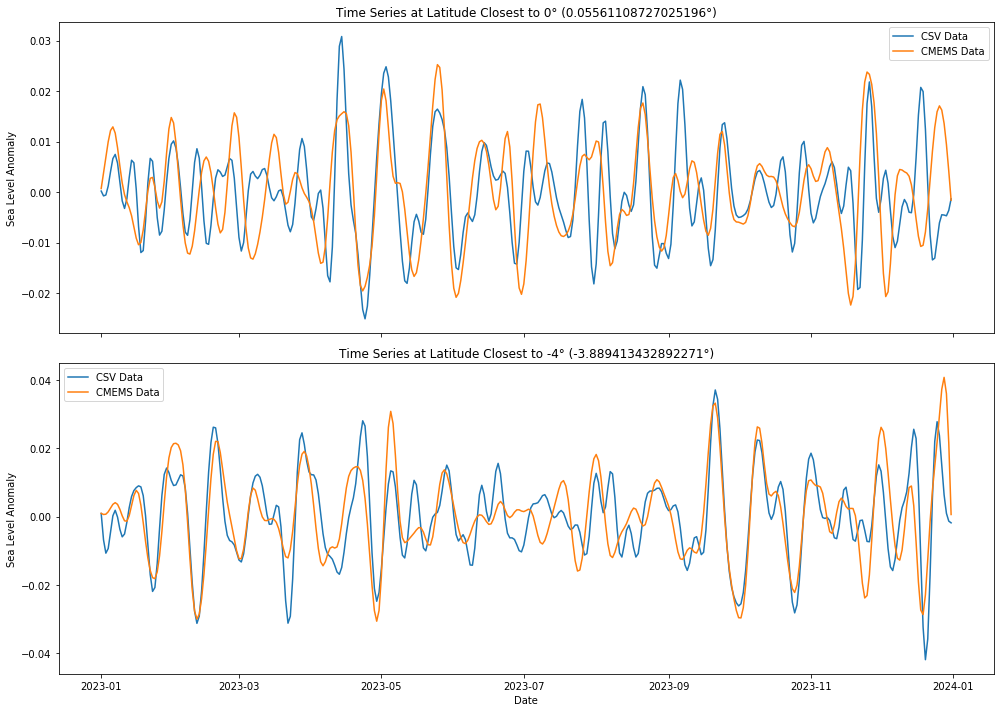

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming latitude_data is already defined and is a pandas DataFrame

# Find the latitude closest to 0 and -4 degrees
closest_to_zero_lat = latitude_data.columns.get_level_values(0).unique()[np.abs(latitude_data.columns.get_level_values(0).unique()).argmin()]
closest_to_minus_four_lat = latitude_data.columns.get_level_values(0).unique()[np.abs(latitude_data.columns.get_level_values(0).unique() + 4).argmin()]

# Extract the time series for these latitudes
csv_zero_lat = latitude_data.xs(('csv', closest_to_zero_lat), axis=1, level=(1, 0))
cmems_zero_lat = latitude_data.xs(('cmems', closest_to_zero_lat), axis=1, level=(1, 0))
csv_minus_four_lat = latitude_data.xs(('csv', closest_to_minus_four_lat), axis=1, level=(1, 0))
cmems_minus_four_lat = latitude_data.xs(('cmems', closest_to_minus_four_lat), axis=1, level=(1, 0))

# Plotting the time series
fig, ax = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Plotting for latitude closest to 0 degrees
ax[0].plot(csv_zero_lat.index, csv_zero_lat, label='CSV Data')
ax[0].plot(cmems_zero_lat.index, cmems_zero_lat, label='CMEMS Data')
ax[0].set_title(f'Time Series at Latitude Closest to 0° ({closest_to_zero_lat}°)')
ax[0].set_ylabel('Sea Level Anomaly')
ax[0].legend()

# Plotting for latitude closest to -4 degrees
ax[1].plot(csv_minus_four_lat.index, csv_minus_four_lat, label='CSV Data')
ax[1].plot(cmems_minus_four_lat.index, cmems_minus_four_lat, label='CMEMS Data')
ax[1].set_title(f'Time Series at Latitude Closest to -4° ({closest_to_minus_four_lat}°)')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Sea Level Anomaly')
ax[1].legend()

plt.tight_layout()
plt.show()


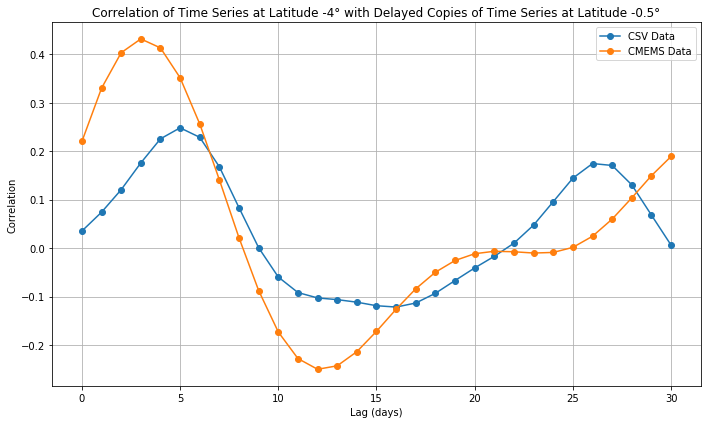

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assuming latitude_data is already defined and is a pandas DataFrame

def find_closest_latitude(latitudes, target):
    return latitudes[np.abs(latitudes - target).argmin()]

def plot_correlations(latitude_data, lat1, lat2, max_lag=30):
    # Find the latitude closest to lat1 and lat2
    latitudes = latitude_data.columns.get_level_values(0).unique()
    closest_lat1 = find_closest_latitude(latitudes, lat1)
    closest_lat2 = find_closest_latitude(latitudes, lat2)

    # Extract the time series for these latitudes
    csv_lat1 = latitude_data.xs(('csv', closest_lat1), axis=1, level=(1, 0)).squeeze()
    cmems_lat1 = latitude_data.xs(('cmems', closest_lat1), axis=1, level=(1, 0)).squeeze()
    csv_lat2 = latitude_data.xs(('csv', closest_lat2), axis=1, level=(1, 0)).squeeze()
    cmems_lat2 = latitude_data.xs(('cmems', closest_lat2), axis=1, level=(1, 0)).squeeze()

    # Function to calculate correlations for different lags
    def calculate_correlations(base_series, delayed_series, max_lag):
        correlations = []
        for lag in range(max_lag + 1):
            if lag == 0:
                correlations.append(base_series.corr(delayed_series))
            else:
                correlations.append(base_series.corr(delayed_series.shift(lag)))
        return correlations

    # Calculate correlations for up to max_lag days lag
    csv_correlations = calculate_correlations(csv_lat2, csv_lat1, max_lag)
    cmems_correlations = calculate_correlations(cmems_lat2, cmems_lat1, max_lag)

    # Plotting the correlations
    lags = np.arange(0, max_lag + 1)
    fig, ax = plt.subplots(figsize=(10, 6))

    ax.plot(lags, csv_correlations, label='CSV Data', marker='o')
    ax.plot(lags, cmems_correlations, label='CMEMS Data', marker='o')
    ax.set_xlabel('Lag (days)')
    ax.set_ylabel('Correlation')
    ax.set_title(f'Correlation of Time Series at Latitude {lat2}° with Delayed Copies of Time Series at Latitude {lat1}°')
    ax.legend()
    ax.grid(True)

    plt.tight_layout()
    plt.show()

# Set your desired latitudes and maximum lag
latitude1 = -0.5  # Replace with your desired latitude value
latitude2 = -4  # Replace with your desired latitude value
max_lag_days = 30  # You can change the maximum lag days as needed

plot_correlations(latitude_data, latitude1, latitude2, max_lag=max_lag_days)


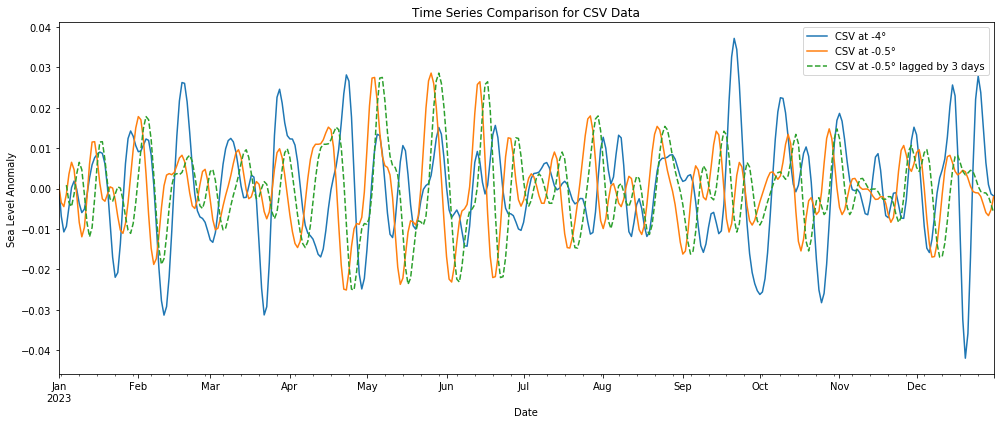

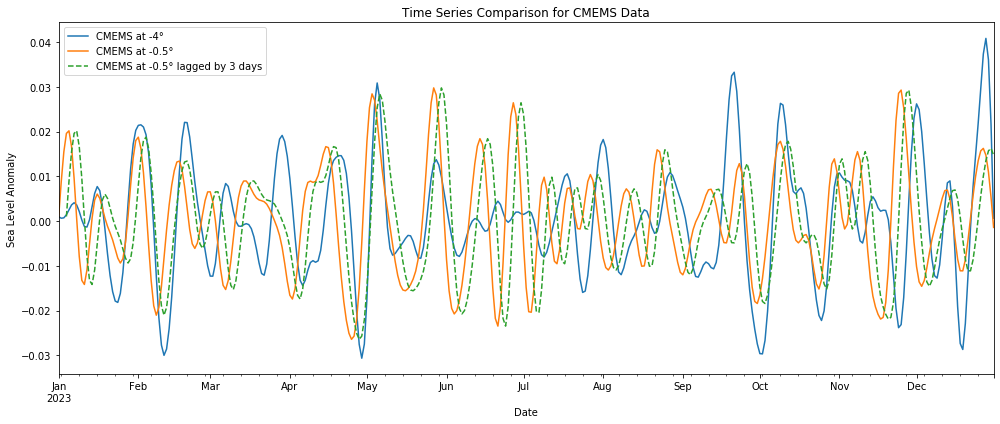

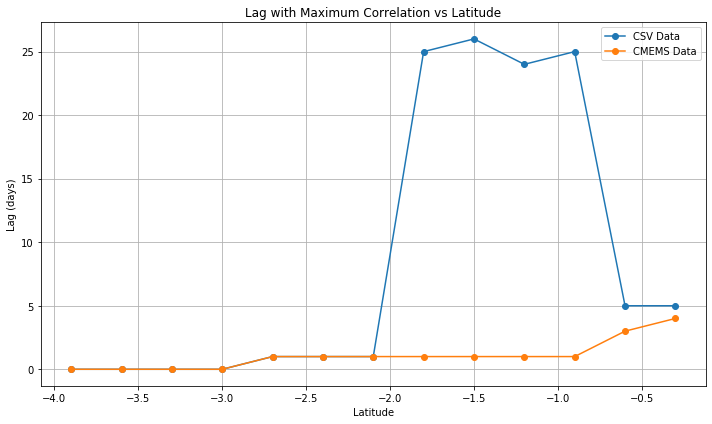

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assuming latitude_data is already defined and is a pandas DataFrame

def find_closest_latitude(latitudes, target):
    return latitudes[np.abs(latitudes - target).argmin()]

def calculate_correlations(base_series, delayed_series, max_lag):
    correlations = []
    for lag in range(max_lag + 1):
        if lag == 0:
            correlations.append(base_series.corr(delayed_series))
        else:
            correlations.append(base_series.corr(delayed_series.shift(lag)))
    return correlations

def find_max_correlation_lag(base_series, latitudes, target_lat, max_lag, dataset):
    max_lag_at_lat = {}
    for lat in latitudes:
        closest_lat = find_closest_latitude(target_lat, lat)
        delayed_series = latitude_data.xs((dataset, closest_lat), axis=1, level=(1, 0)).squeeze()
        correlations = calculate_correlations(base_series, delayed_series, max_lag)
        max_corr_lag = np.argmax(correlations)
        max_lag_at_lat[lat] = max_corr_lag
    return max_lag_at_lat

def plot_time_series_comparison(latitude_data, target_lat, compare_lat, lag_days, dataset):
    closest_to_target_lat = find_closest_latitude(latitude_data.columns.get_level_values(0).unique(), target_lat)
    closest_to_compare_lat = find_closest_latitude(latitude_data.columns.get_level_values(0).unique(), compare_lat)
    
    base_series = latitude_data.xs((dataset, closest_to_target_lat), axis=1, level=(1, 0)).squeeze()
    compare_series = latitude_data.xs((dataset, closest_to_compare_lat), axis=1, level=(1, 0)).squeeze()
    lagged_series = compare_series.shift(lag_days)
    
    fig, ax = plt.subplots(figsize=(14, 6))
    base_series.plot(ax=ax, label=f'{dataset.upper()} at {target_lat}°')
    compare_series.plot(ax=ax, label=f'{dataset.upper()} at {compare_lat}°')
    lagged_series.plot(ax=ax, label=f'{dataset.upper()} at {compare_lat}° lagged by {lag_days} days', linestyle='--')
    ax.set_title(f'Time Series Comparison for {dataset.upper()} Data')
    ax.set_xlabel('Date')
    ax.set_ylabel('Sea Level Anomaly')
    ax.legend()
    plt.tight_layout()
    plt.show()

# Set your desired range of latitudes and maximum lag
latitude_range = np.arange(-0.3, -4.1, -0.3)  # Latitudes from -0.3 to -4 spaced by 0.3 degrees
target_lat = -4  # Reference latitude
compare_lat = -0.5  # Latitude to compare
lag_days = 3  # Lag days

# Plot the time series comparison for CSV data
plot_time_series_comparison(latitude_data, target_lat, compare_lat, lag_days, 'csv')

# Plot the time series comparison for CMEMS data
plot_time_series_comparison(latitude_data, target_lat, compare_lat, lag_days, 'cmems')

# Extract the base time series for the reference latitude (-4 degrees) for both datasets
closest_to_target_lat_csv = find_closest_latitude(latitude_data.columns.get_level_values(0).unique(), target_lat)
closest_to_target_lat_cmems = find_closest_latitude(latitude_data.columns.get_level_values(0).unique(), target_lat)

base_series_csv = latitude_data.xs(('csv', closest_to_target_lat_csv), axis=1, level=(1, 0)).squeeze()
base_series_cmems = latitude_data.xs(('cmems', closest_to_target_lat_cmems), axis=1, level=(1, 0)).squeeze()

# Find the lag with the maximum correlation for each latitude in the range for both datasets
max_correlation_lags_csv = find_max_correlation_lag(base_series_csv, latitude_range, latitude_data.columns.get_level_values(0).unique(), max_lag_days, 'csv')
max_correlation_lags_cmems = find_max_correlation_lag(base_series_cmems, latitude_range, latitude_data.columns.get_level_values(0).unique(), max_lag_days, 'cmems')

# Plotting the lag with maximum correlation against the latitude for both datasets
latitudes_csv = list(max_correlation_lags_csv.keys())
lags_csv = list(max_correlation_lags_csv.values())

latitudes_cmems = list(max_correlation_lags_cmems.keys())
lags_cmems = list(max_correlation_lags_cmems.values())

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(latitudes_csv, lags_csv, marker='o', linestyle='-', label='CSV Data')
ax.plot(latitudes_cmems, lags_cmems, marker='o', linestyle='-', label='CMEMS Data')
ax.set_xlabel('Latitude')
ax.set_ylabel('Lag (days)')
ax.set_title('Lag with Maximum Correlation vs Latitude')
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()


    # Mikes stuff for Marcello

In [9]:
import xarray as xr
import pygmt

ModuleNotFoundError: No module named 'pygmt'

In [ ]:
nc = xr.open_dataset("/DGFI8/H/work_mike/SWOT_Data/SWOT_Franck_3.nc") # gridded SWOT data

NC = nc.ssh[0]

lons = np.array(lons)
lats = np.array(lats)

In [ ]:
marcello = np.zeros((len(nc.ssh),len(lons)))

for m in range(len(nc.ssh)):
    
    nlon = np.ravel(nc.lon)
    nlat = np.ravel(nc.lat)
    nssh = np.ravel(nc.ssh[m])

    md = pygmt.xyz2grd(x=nlon,y=nlat,z=nssh,region='8/13/-20/5',spacing=0.02)

    md = md.interpolate_na(dim="x", method="nearest", fill_value="extrapolate")
    md = md.interpolate_na(dim="y", method="nearest", fill_value="extrapolate")

#     ind = np.where((lons<15)&(lons>0)&(lats<5)&(lats>-20))[0]
    pas = md.sel(x=lons,y=lats,method='nearest')
    mas = np.nanmean(pas.data,axis=1)

    marcello[m] = mas

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

vmax = .3
vmin = -vmax
c1 = ax[0].pcolormesh(latitude_data.index, latitude_data.columns.get_level_values(0).unique(), 
                      latitude_data.xs('csv', axis=1, level=1).T,#-np.nanmean(latitude_data.xs('csv', axis=1, level=1).T,axis=0), 
                      shading='auto', cmap='RdYlBu_r',
                     vmax=vmax,vmin=vmin)
ax[0].set_title('Hovmöller Diagram (CSV Data)')
ax[0].set_ylabel('Latitude')
fig.colorbar(c1, ax=ax[0], orientation='vertical', label='Sea Level Anomaly')

# Hovmöller diagram for CMEMS data
c2 = ax[1].pcolormesh(latitude_data.index, latitude_data.columns.get_level_values(0).unique(), 
                      latitude_data.xs('cmems', axis=1, level=1).T,#-np.nanmean(latitude_data.xs('cmems', axis=1, level=1).T,axis=0), 
                      shading='auto', cmap='RdYlBu_r',
                     vmax=vmax,vmin=vmin)

ax[1].set_title('Hovmöller Diagram (CMEMS Data)')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Latitude')
fig.colorbar(c2, ax=ax[1], orientation='vertical', label='Sea Level Anomaly')

plt.tight_layout()

cb = ax[2].pcolormesh(nc.t,lats,marcello.T,vmax=vmax,vmin=vmin
                    ,cmap=plt.cm.RdYlBu_r)
ax[0].set_ylim(-4,4)
ax[1].set_ylim(-4,4)
ax[2].set_ylim(-4,4)
plt.colorbar(cb)
ax[2].set_title('Hovmöller Diagram (SWOT Cal/Val Data)')


In [ ]:
df = latitude_data.xs('cmems', axis=1, level=1).T
df['index_col'] = df.index
df = df.reset_index(drop=True)

lk = latitude_data.xs('csv', axis=1, level=1).T
lk['index_col'] = lk.index
lk = lk.reset_index(drop=True)

plt.figure(figsize=(15,10),dpi=320)

for l in range(70):
    plt.subplot(7,10,l+1)
    plt.plot(nc.t,marcello.T[l])
    plt.plot(lk.T.index[:-1],np.array(lk.T[l])[:-1])
    plt.plot(df.T.index[:-1],np.array(df.T[l])[:-1])

In [ ]:
plt.figure(figsize=(15,5),dpi=320)

l = 0

plt.plot(nc.t,marcello.T[l])
plt.plot(lk.T.index[:-1],np.array(lk.T[l])[:-1])
plt.plot(df.T.index[:-1],np.array(df.T[l])[:-1])